<div class="alert alert-warning">
    
<b>Disclaimer:</b> 
    
The main objective of the <i>Jupyter</i> notebooks is to show how to use the models of the <i>QENS library</i> by
    
- building a fitting model: composition of models, convolution with a resolution function  
- setting and running the fit  
- extracting and displaying information about the results  

These steps have a minimizer-dependent syntax. That's one of the reasons why different minimizers have been used in the notebooks provided as examples.  
But, the initial guessed parameters might not be optimal, resulting in a poor fit of the reference data.

</div> 

# Two Lorentzian &lowast; resolution with lmfit

## Introduction

<div class="alert alert-info">
    
The objective of this notebook is to show how to use one of the models of 
the <a href="https://github.com/QENSlibrary/QENSmodels">QENSlibrary</a>, <b>Lorentzian</b>, to perform some fits.
<a href="https://lmfit.github.io/lmfit-py/">lmfit</a> is used for fitting.
</div>

The following example uses the data from IRIS:
- workspace_index=0, file: `irs26176_graphite002_red.nxs`  
- related instrument resolution data `irs26173_graphite002_res.nxs`   

The ISIS sample datasets can be downloaded from [Mantid's website](http://download.mantidproject.org/).
The data used for this example are in the sample datafile: `data_2lorentzians.dat` and the instrument resolution datafile `irf_iris.dat`, respectively.

This example is based on a [Mantid "Fitting QENS Peaks" tutorial](https://www.mantidproject.org/Fitting_QENS_Peaks).

The implementation with `lmfit` is based on https://lmfit.github.io/lmfit-py/model.html

This example requires an additional Python module `scipy.interpolate` to interpolate the tabulated data of the instrument resolution.

### Physical units
For information about unit conversion, please refer to the jupyter notebook called `Convert_units.ipynb` in the `tools` folder.

The dictionary of units defined in the cell below specify the units of the refined parameters adapted to the convention used in the experimental datafile.

In [1]:
# Units of parameters for selected QENS model and experimental data
dict_physical_units = {'omega': "meV", 
                       'q': "1/Angstrom", 
                       'hwhm': "meV", 
                       'scale': "unit_of_signal.meV",
                       'center': "meV"}

## Importing the required librairies

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets
from lmfit import Model, CompositeModel
from scipy.interpolate import interp1d
import QENSmodels

path_to_data = './data/'

## Importing the reference data

In [3]:
# Create model - 2 lorentzians convoluted with instrument resolution - 6 parameters
# Step 1 load instrument resolution data
irf_iris = np.loadtxt(path_to_data + 'irf_iris.dat')
x_irf = irf_iris[:, 0]
y_irf = irf_iris[:, 1]

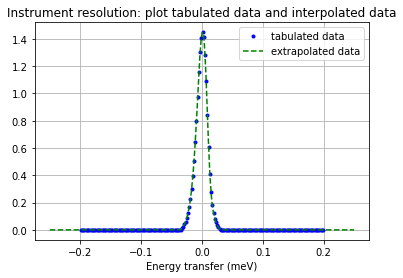

In [4]:
# Step 2: create function for instrument resolution data (cubic interpolation between tabulated data points)

def irf_gate(x):
    """ 
    Function defined from the interpolation of instrument resolution data 
    Used to define fitting model and plot
    """ 
    f = interp1d(x_irf, y_irf, kind='cubic', bounds_error=False, fill_value='extrapolate')

    return f(x)

# plot tabulated data and interpolated data
xx = np.linspace(-.25, .25, 500)

fig0, ax0 = plt.subplots()
ax0.plot(x_irf, y_irf, 'b.', label='tabulated data')
ax0.plot(xx, irf_gate(xx), 'g--', label='extrapolated data')
ax0.legend()
ax0.set(xlabel='Energy transfer (meV)', 
        title='Instrument resolution: plot tabulated data and interpolated data')
ax0.grid();

## Setting and fitting

In [5]:
# Step 3: create "double lorentzian" profile
def model_2lorentzians(x, scale1, center1, hwhm1, scale2, center2, hwhm2):
    return QENSmodels.lorentzian(x, scale1, center1, hwhm1) + QENSmodels.lorentzian(x, scale2, center2, hwhm2)

In [6]:
# Step 4: create convolution function 
# code from https://github.com/jmborr/qef

def convolve(model, resolution):
    c = np.convolve(model, resolution, mode='valid')
    if len(model) % len(resolution) == 0:
        c = c[:-1]
    return c

class Convolve(CompositeModel):
    def __init__(self, resolution, model, **kws):
        super(Convolve, self).__init__(resolution, model, convolve, **kws)
        self.resolution = resolution
        self.model = model

    def eval(self, params=None, **kwargs):
        res_data = self.resolution.eval(params=params, **kwargs)
        
        # evaluate model on an extended energy range to avoid boundary effects
        independent_var = self.resolution.independent_vars[0]
        e = kwargs[independent_var]  # energy values
        neg_e = min(e) - np.flip(e[np.where(e > 0)], axis=0)
        pos_e = max(e) - np.flip(e[np.where(e < 0)], axis=0)
        e = np.concatenate((neg_e, e, pos_e))
        kwargs.update({independent_var: e})
        model_data = self.model.eval(params=params, **kwargs)
        
        # Multiply by the X-spacing to preserve normalization
        de = (e[-1] - e[0])/(len(e) - 1)  # energy spacing
        return de * convolve(model_data, res_data)

In [7]:
# Load reference data - extract x and y values
two_lorentzians_iris = np.loadtxt(path_to_data + 'data_2lorentzians.dat')
xx = two_lorentzians_iris[:, 0]
yy = two_lorentzians_iris[:, 1]

In [8]:
gmodel = Convolve(Model(irf_gate), Model(model_2lorentzians))

In [9]:
# Fit
result = gmodel.fit(yy, x=xx, scale1=1., center1=0., hwhm1=0.25, scale2=5., center2=0., hwhm2=0.02)

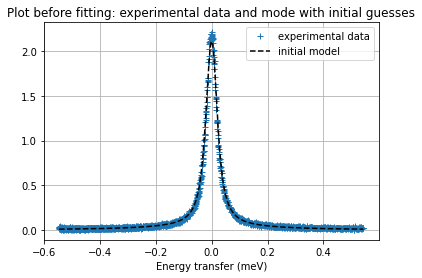

In [10]:
fig1 = plt.figure()
plt.plot(xx, yy, '+', label='experimental data')
plt.plot(xx, result.init_fit, 'k--', label='initial model')
plt.legend(loc='upper right')
plt.xlabel('Energy transfer (meV)') 
plt.title('Plot before fitting: experimental data and mode with initial guesses')
plt.grid();

## Plotting results

In [28]:
# display result
print('Result of fit:\n', result.fit_report())

Result of fit:
 [[Model]]
    (Model(irf_gate) <function convolve at 0x1045494c0> Model(model_2lorentzians))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 71
    # data points      = 1905
    # variables        = 6
    chi-square         = 0.39263649
    reduced chi-square = 2.0676e-04
    Akaike info crit   = -16155.9414
    Bayesian info crit = -16122.6280
[[Variables]]
    scale1:   1.42320489 +/- 0.01978767 (1.39%) (init = 1)
    center1:  0.01133980 +/- 0.00188522 (16.62%) (init = 0)
    hwhm1:    0.15085739 +/- 0.00439867 (2.92%) (init = 0.25)
    scale2:   4.36352028 +/- 0.01712183 (0.39%) (init = 5)
    center2: -0.00111518 +/- 2.8724e-05 (2.58%) (init = 0)
    hwhm2:    0.01651626 +/- 7.3516e-05 (0.45%) (init = 0.02)
[[Correlations]] (unreported correlations are < 0.100)
    C(scale2, hwhm2)    = 0.919
    C(hwhm1, scale2)    = 0.805
    C(hwhm1, hwhm2)     = 0.673
    C(scale1, hwhm2)    = -0.539
    C(scale1, scale2)   = -0.537
    C(center1, s

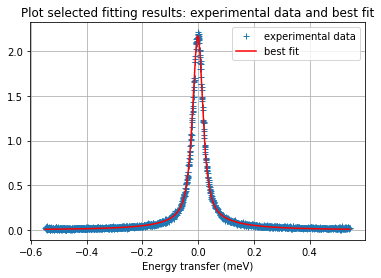

In [11]:
# plot selected results: experimental data and best fit
fig2 = plt.figure()
plt.plot(xx, yy, '+', label='experimental data')
plt.plot(xx, result.best_fit, 'r-', label='best fit')
plt.grid()
plt.xlabel('Energy transfer (meV)')
plt.title('Plot selected fitting results: experimental data and best fit')
plt.legend();

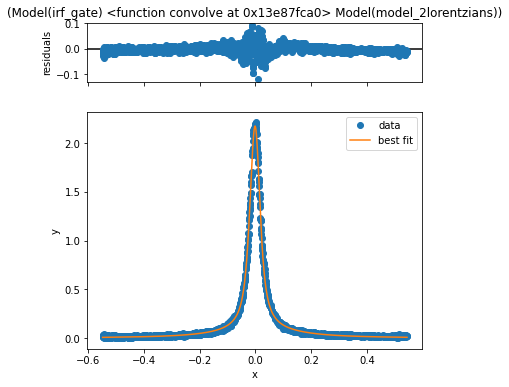

In [18]:
# other option to plot result using lmfit's features
result.plot();

In [13]:
for item in result.params.keys():
    print(f"{item[:-1]: <6}: {result.params[item].value: .12f} +/- {result.params[item].stderr:.12f} {dict_physical_units[item[:-1]]}")

scale :  1.423204887802 +/- 0.019787670088 unit_of_signal.meV
center:  0.011339803078 +/- 0.001885215206 meV
hwhm  :  0.150857389849 +/- 0.004398668939 meV
scale :  4.363520279453 +/- 0.017121826802 unit_of_signal.meV
center: -0.001115183378 +/- 0.000028724162 meV
hwhm  :  0.016516255189 +/- 0.000073516089 meV
